In [206]:
# NB. Run this in Google colab NOT Jupyter lab.  https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index#recent=true
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [207]:
# Import libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [208]:
sf_df = pd.read_csv('zillow_singlefamily_CA.csv',index_col=0)

In [209]:
# Make sure to set the zip codes down the rows
sf_df

,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,...,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,4/30/2021
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94109,831440,833601,836753,836778,835625,826063,821906,819361,825358,830436,831750,834717,852284,863637,870019,862421,867464,885304,902764,917391,921902,928266,939778,949482,946603,952385,960843,996801,1019035,1042605,1054635,1068193,1083316,1099892,1122297,1142549,1147654,1153793,1162982,1183334,...,2932975,2947249,2967942,2990547,2996340,3012091,2991050,2964542,2937204,2955553,2978808,2975834,2983027,2978372,2970893,2943754,2942083,2953094,2959115,2945923,2934268,2939651,2953089,2974365,2981927,2987869,2977935,2972172,2948986,2921041,2912272,2917681,2921937,2893815,2860012,2829785,2805510,2783214,2771183,2762715
90250,174560,174875,175233,175872,176485,176927,177268,177322,177147,176900,176806,176790,176101,175167,174223,173915,173573,173501,173797,174615,175560,176379,176815,177468,178842,180927,182763,184006,185279,186157,186478,186712,187582,188899,190471,191518,193059,194107,195483,196515,...,625645,630873,637497,642482,646843,650489,654542,656690,658599,661020,663797,664841,664833,662398,660485,660567,664970,670133,671606,671618,671838,673417,675293,680390,686574,693936,700364,705357,707070,708085,713403,721377,730029,738233,746198,752857,759593,767378,776266,786609
94565,221186,219045,218123,215944,214768,213396,212393,211581,211253,210741,210830,211403,213642,216214,217564,218251,218362,218772,218414,218530,219500,220510,220977,221377,217479,214022,210949,212300,214160,216852,220503,223424,224237,226211,228181,229749,235338,242332,250897,253208,...,581414,587536,591528,591471,594056,597598,602005,600738,601778,602115,602277,598989,598022,596035,594193,592133,594062,595257,595171,592386,589107,588198,589431,594123,594581,594878,596402,599557,599379,599368,601293,608435,615110,621912,627336,632676,640614,650819,661699,673605
90046,375709,377194,377461,377721,377976,378593,380761,382134,384002,385344,387271,389102,390368,390664,393010,397842,402385,406192,408701,413098,416337,420546,424535,430004,436740,443695,448839,452165,457413,463094,467194,471251,477768,485282,491619,496063,500039,505086,509501,514567,...,1762945,1782654,1805289,1817917,1814517,1809425,1801777,1798665,1794889,1801591,1810904,1814211,1813573,1803190,1795536,1795226,1808843,1821803,1810064,1796517,1788719,1800886,1806957,1814032,1816805,1828669,1840372,1851721,1856320,1861663,1889021,1916041,1938622,1941733,1947596,1956420,1970461,1982598,1993683,2003831
94501,247495,246294,246079,245611,245742,244970,243969,243353,243490,244285,245161,246324,247111,248574,249683,251069,252747,255640,258877,261390,263429,265041,267037,269680,272649,276092,279220,282348,284238,286431,289577,293367,297332,299789,302601,303809,306450,308464,311188,311695,...,1069914,1079241,1081968,1087758,1096654,1101677,1094542,1089322,1078669,1080633,1079501,1073064,1063076,1058076,1062260,1069610,1081379,1091699,1104635,1106003,1109077,1103860,1102213,1111072,1130426,1141873,1146482,1141146,1136592,1132327,1135109,1147393,1161592,1178943,1195897,1208408,1216416,1231359,1251166,1279998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# New Section

In [210]:
# set the random seed
np.random.seed(42)
#remove text column headers
data = sf_df.values

Scale the data


In [211]:
# Scale the data so that the model doesn't take too long to run (and to remove all units to ensure all features are on the same footing)
from sklearn.preprocessing import MinMaxScaler
data_scaled = MinMaxScaler().fit(data).transform(data)

In [212]:
data_scaled.shape

(1714, 304)

Define training/testing/validation cells

In [213]:
train_stop = 1414
valid_stop = 1614
n_steps = len(sf_df.columns)
n_steps

304

In [214]:
# split the data into test, training and validation sets
X_train, y_train = data_scaled[:train_stop,:-1], data_scaled[:train_stop,-1]
X_valid, y_valid = data_scaled[train_stop:valid_stop,:-1], data_scaled[train_stop:valid_stop,-1]
X_test, y_test =   data_scaled[valid_stop:,:-1], data_scaled[valid_stop:,-1]

In [215]:
y_train = np.expand_dims(y_train,-1)
y_valid = np.expand_dims(y_valid,-1)
y_test = np.expand_dims(y_test,-1)
X_train = np.expand_dims(X_train,-1)
X_valid = np.expand_dims(X_valid,-1)
X_test = np.expand_dims(X_test,-1)

In [216]:
# Define a function to plot our sample
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 1])


In [217]:
X_valid[0,:,0].shape

(303,)

Saving figure time_series_plot


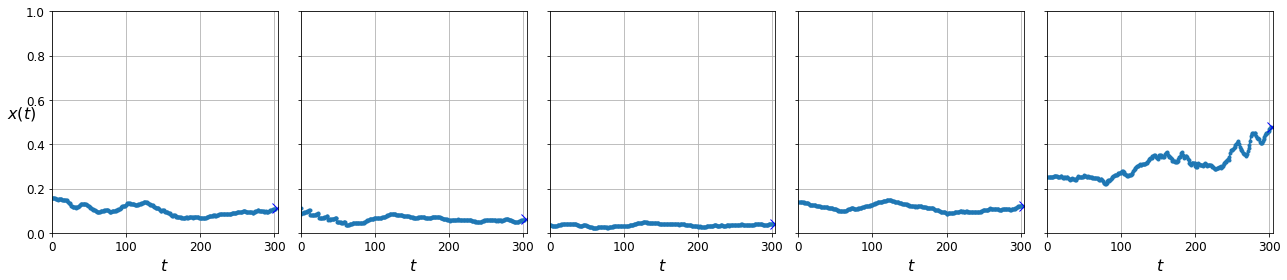

In [218]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18, 4))
for col in range(5):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()
# 'x' in the graphs is what we are trying to predict

Establish a baseline

In [219]:
#Assume the base prediction is simply the last datapoint in the series
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

1.2422560301540405e-06

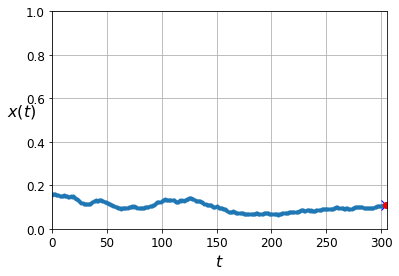

In [220]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [221]:
np.random.seed(42)
tf.random.set_seed(42)

In [222]:
# Deep RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
    #This gives us 2 hidden layers and 1 layer at the end (the final number!. return_sequences=true ensures it passes the entire time series along at each layer)
])

In [223]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [225]:
# We tried up to 20 epochs but the model started to exhibit signs of overfitting (training loss < validation loss) so we decided to stop at 6.
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=6,
                    validation_data=(X_valid, y_valid))

Epoch 1/6
45/45 [==============================] - 29s 614ms/step - loss: 0.0266 - val_loss: 4.7489e-04
Epoch 2/6
45/45 [==============================] - 27s 610ms/step - loss: 6.7572e-04 - val_loss: 4.7005e-04
Epoch 3/6
45/45 [==============================] - 29s 635ms/step - loss: 4.7825e-04 - val_loss: 4.6528e-04
Epoch 4/6
45/45 [==============================] - 27s 607ms/step - loss: 3.5555e-04 - val_loss: 3.7166e-04
Epoch 5/6
45/45 [==============================] - 27s 609ms/step - loss: 3.0466e-04 - val_loss: 3.6233e-04
Epoch 6/6
45/45 [==============================] - 28s 620ms/step - loss: 3.0738e-04 - val_loss: 3.3046e-04


In [226]:
model.evaluate(X_valid, y_valid)
# we want our loss function to be as close to 0 as possible

7/7 [==============================] - 0s 58ms/step - loss: 3.3046e-04


0.00033045641612261534

In [227]:
model.save("singlefamily_trained.hdf5")

In [228]:
X_train[:,1:,:].shape

(1414, 302, 1)

In [229]:
y_train[:,].shape

(1414, 1)

In [230]:
# Model evaluations
model.evaluate(X_train,y_train)

45/45 [==============================] - 3s 58ms/step - loss: 2.4859e-04


0.00024858719552867115

In [231]:
model.evaluate(X_valid,y_valid)

7/7 [==============================] - 0s 62ms/step - loss: 3.3046e-04


0.00033045641612261534

In [232]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 63ms/step - loss: 4.3683e-04


0.0004368299269117415

In [233]:
# X_train: Use expand_dims in order to give the y_train an extra dimension.
x_train_pred = np.concatenate((X_train[:,1:,:],np.expand_dims(y_train,-1)),axis=1)

In [234]:
# build y_train prediction
y_train_pred = model.predict(x_train_pred)
y_train_pred.shape

(1414, 1)

In [235]:
# X_valid: Use expand_dims in order to give the y_train an extra dimension.
x_valid_pred = np.concatenate((X_valid[:,1:,:],np.expand_dims(y_valid,-1)),axis=1)

In [236]:
# build y_valid prediction
y_valid_pred = model.predict(x_valid_pred)
y_valid_pred.shape

(200, 1)

In [237]:
# X_test: Use expand_dims in order to give the y_train an extra dimension.
x_test_pred = np.concatenate((X_test[:,1:,:],np.expand_dims(y_test,-1)),axis=1)

In [238]:
# build y_test prediction
y_test_pred = model.predict(x_test_pred)
y_test_pred.shape

(100, 1)

In [239]:
# concatenate all three y_pred series together and append them to the original data
y_pred_all = np.concatenate((y_train_pred,y_valid_pred,y_test_pred),axis=0)
y_pred_all_df = pd.DataFrame(y_pred_all).astype('float')
y_pred_all_df

,0
0,0.447360
1,0.105549
2,0.094214
3,0.271793
4,0.161444
...,...
1709,0.061603
1710,0.074570
1711,0.059050
1712,0.032878


In [240]:
sf_df['5/31/2021'] = y_pred_all_df[0].values

In [241]:
sf_df["max"]=sf_df.iloc[:,0:-2].max(axis=1)

In [242]:
sf_df["min"]=sf_df.iloc[:,0:-3].min(axis=1)


In [243]:
sf_df['5/31/2021_scaled'] = sf_df['5/31/2021']*(sf_df['max']-sf_df['min'])+sf_df['min']

In [244]:
sf_final_df = sf_df.drop(['max','min','5/31/2021'],axis=1)


In [245]:
sf_final_df.rename(columns={'5/31/2021_scaled':'5/31/2021'},inplace=True)
sf_final_df

,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,...,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,4/30/2021,5/31/2021
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94109,831440,833601,836753,836778,835625,826063,821906,819361,825358,830436,831750,834717,852284,863637,870019,862421,867464,885304,902764,917391,921902,928266,939778,949482,946603,952385,960843,996801,1019035,1042605,1054635,1068193,1083316,1099892,1122297,1142549,1147654,1153793,1162982,1183334,...,2947249,2967942,2990547,2996340,3012091,2991050,2964542,2937204,2955553,2978808,2975834,2983027,2978372,2970893,2943754,2942083,2953094,2959115,2945923,2934268,2939651,2953089,2974365,2981927,2987869,2977935,2972172,2948986,2921041,2912272,2917681,2921937,2893815,2860012,2829785,2805510,2783214,2771183,2762715,1.832715e+06
90250,174560,174875,175233,175872,176485,176927,177268,177322,177147,176900,176806,176790,176101,175167,174223,173915,173573,173501,173797,174615,175560,176379,176815,177468,178842,180927,182763,184006,185279,186157,186478,186712,187582,188899,190471,191518,193059,194107,195483,196515,...,630873,637497,642482,646843,650489,654542,656690,658599,661020,663797,664841,664833,662398,660485,660567,664970,670133,671606,671618,671838,673417,675293,680390,686574,693936,700364,705357,707070,708085,713403,721377,730029,738233,746198,752857,759593,767378,776266,786609,2.371220e+05
94565,221186,219045,218123,215944,214768,213396,212393,211581,211253,210741,210830,211403,213642,216214,217564,218251,218362,218772,218414,218530,219500,220510,220977,221377,217479,214022,210949,212300,214160,216852,220503,223424,224237,226211,228181,229749,235338,242332,250897,253208,...,587536,591528,591471,594056,597598,602005,600738,601778,602115,602277,598989,598022,596035,594193,592133,594062,595257,595171,592386,589107,588198,589431,594123,594581,594878,596402,599557,599379,599368,601293,608435,615110,621912,627336,632676,640614,650819,661699,673605,2.623152e+05
90046,375709,377194,377461,377721,377976,378593,380761,382134,384002,385344,387271,389102,390368,390664,393010,397842,402385,406192,408701,413098,416337,420546,424535,430004,436740,443695,448839,452165,457413,463094,467194,471251,477768,485282,491619,496063,500039,505086,509501,514567,...,1782654,1805289,1817917,1814517,1809425,1801777,1798665,1794889,1801591,1810904,1814211,1813573,1803190,1795536,1795226,1808843,1821803,1810064,1796517,1788719,1800886,1806957,1814032,1816805,1828669,1840372,1851721,1856320,1861663,1889021,1916041,1938622,1941733,1947596,1956420,1970461,1982598,1993683,2003831,8.154630e+05
94501,247495,246294,246079,245611,245742,244970,243969,243353,243490,244285,245161,246324,247111,248574,249683,251069,252747,255640,258877,261390,263429,265041,267037,269680,272649,276092,279220,282348,284238,286431,289577,293367,297332,299789,302601,303809,306450,308464,311188,311695,...,1079241,1081968,1087758,1096654,1101677,1094542,1089322,1078669,1080633,1079501,1073064,1063076,1058076,1062260,1069610,1081379,1091699,1104635,1106003,1109077,1103860,1102213,1111072,1130426,1141873,1146482,1141146,1136592,1132327,1135109,1147393,1161592,1178943,1195897,1208408,1216416,1231359,1251166,1279998,4.060587e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [246]:
sf_final_df.to_csv('single_family_final.csv',index=True)